## Import packages and set config

In [1]:

#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import Dataset

import random

/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Smaller than the original GPT-2, only 6 layers (instead of 12), 12 heads, 768 dimensions (like GPT-2)
model_name = "distilgpt2" # "gpt2-medium" # distilgpt2 #gpt2-large it reachs the maximum gpu capacity
experiment_name = "banking"

## Load data

In [3]:
df = pd.read_csv(f"/hadatasets/fillipe.silva/LLMSegm/data/{experiment_name}/train.csv", sep=";")
columns = df.columns.tolist()
ds = Dataset.from_pandas(df)
print(df.shape, df.head())

(45211, 17)    age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


### Prepare the tabular data

In [4]:
def combine_data_ordered(sample):
    concat = ""
    for col in columns:
        concat += "%s is %s, " % (col, str(sample[col]).strip())

    return {"concat": concat}

def combine_data_shuffled(sample):
    concat = ""
    for col in random.sample(columns, k=len(columns)):
        concat += "%s is %s, " % (col, str(sample[col]).strip())

    return {"concat": concat}

# Shuffle the features or not
shuffle = True 
if shuffle:
    combined_ds = ds.map(combine_data_shuffled)
else:
    combined_ds = ds.map(combine_data_ordered)

combined_ds = combined_ds.remove_columns(ds.column_names)
print(combined_ds["concat"][0])

Map:   0%|          | 0/45211 [00:00<?, ? examples/s]

Map: 100%|██████████| 45211/45211 [00:11<00:00, 3894.93 examples/s]


campaign is 1, day is 5, housing is yes, previous is 0, poutcome is unknown, pdays is -1, month is may, education is tertiary, contact is unknown, age is 58, loan is no, marital is married, job is management, duration is 261, balance is 2143, default is no, y is no, 


### Tokenize the data

In [5]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

max_length = 125
def tokenizer_function(sample):
    result = tokenizer(sample["concat"], truncation=True, padding="max_length", max_length=max_length)
    result["labels"] = result["input_ids"].copy()
    return result

# Tokenize dataset and create pytorch tensors
tokenizer_ds = combined_ds.map(tokenizer_function, batched=True)
tokenizer_ds.set_format("torch")

/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 45211/45211 [00:05<00:00, 8427.95 examples/s]


### Train Model

In [7]:
model = AutoModelForCausalLM.from_pretrained(model_name)
epochs = 25
batch_size = 16
training_args = TrainingArguments(f"/hadatasets/fillipe.silva/LLMSegm/models/{experiment_name}", 
                                  num_train_epochs=epochs, 
                                  per_device_train_batch_size=batch_size,
                                  save_steps=5000)
trainer = Trainer(model, training_args, train_dataset=tokenizer_ds, tokenizer=tokenizer)

/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
trainer.train() # resume_from_checkpoint = True

/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.678500
1000,0.541300
1500,0.529600
2000,0.523800
2500,0.520100
3000,0.518000
3500,0.516100
4000,0.514200
4500,0.513200
5000,0.512200


/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=17675, training_loss=0.5139988404183611, metrics={'train_runtime': 8287.0091, 'train_samples_per_second': 136.391, 'train_steps_per_second': 2.133, 'total_flos': 3.60519024384e+16, 'train_loss': 0.5139988404183611, 'epoch': 25.0})

### Save Model

In [9]:
model_name = model_name + "_" + str(epochs) + ".pt"
model_path = f"/hadatasets/fillipe.silva/LLMSegm/models/{experiment_name}/{model_name}"
torch.save(model.state_dict(), model_path)

### Look at loss curve

The trainer.state.log_history contains some information about the training.
Just saving the loss curve, but one could also save the whole state of the trainer.

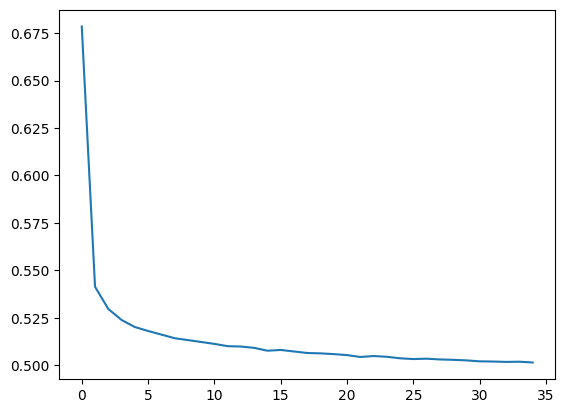

In [10]:
rounds = len(trainer.state.log_history) - 1
loss = [x["loss"] if i < rounds else None for i, x in enumerate(trainer.state.log_history)]
plt.plot(loss)

## Getting Embeddings 

In [11]:
val_df = pd.read_csv(f"/hadatasets/fillipe.silva/LLMSegm/data/{experiment_name}/test.csv", sep=";")
columns = val_df.columns.tolist()
ds = Dataset.from_pandas(val_df)

In [12]:
def combine_data_ordered(sample):
    concat = ""
    for col in columns:
        concat += "%s is %s, " % (col, str(sample[col]).strip())

    return {"concat": concat}

def combine_data_shuffled(sample):
    concat = ""
    for col in random.sample(columns, k=len(columns)):
        concat += "%s is %s, " % (col, str(sample[col]).strip())

    return {"concat": concat}

combined_ds = ds.map(combine_data_shuffled)
combined_ds["concat"][0]

Map: 100%|██████████| 4521/4521 [00:01<00:00, 3440.72 examples/s]


'education is primary, age is 30, duration is 79, default is no, y is no, campaign is 1, marital is married, job is unemployed, contact is cellular, day is 19, pdays is -1, previous is 0, poutcome is unknown, housing is no, balance is 1787, month is oct, loan is no, '

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

embs = []
for text in combined_ds["concat"]:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model(**inputs)

    # Extract logits
    logits = outputs.logits

    # Use logits as text embeddings
    text_embedding = logits[:, -1, :]  # Take the last token's logits as the embedding

    # Convert tensor to numpy array if needed
    text_embedding_np = text_embedding.detach().cpu().numpy()

    embs.append(text_embedding_np[0])

'''other option to do embds (not tested)
token_ids = tokenizer.encode("Your input text goes here", add_special_tokens=False)

# Convert token IDs to tensor and move it to the model's device
tokens_tensor = torch.tensor([token_ids], device=model.device)
with torch.no_grad():
# Forward pass through the model
outputs = model(tokens_tensor)
# Retrieve the hidden states from the model output
hidden_states = outputs[0]  # 'outputs' is a tuple, the first element is the hidden states

# Averaging over the sequence length
print(len((hidden_states[0].mean(dim=0))), (hidden_states[0].mean(dim=0)))
'''

'other option to do embds (not tested)\ntoken_ids = tokenizer.encode("Your input text goes here", add_special_tokens=False)\n\n# Convert token IDs to tensor and move it to the model\'s device\ntokens_tensor = torch.tensor([token_ids], device=model.device)\nwith torch.no_grad():\n# Forward pass through the model\noutputs = model(tokens_tensor)\n# Retrieve the hidden states from the model output\nhidden_states = outputs[0]  # \'outputs\' is a tuple, the first element is the hidden states\n\n# Averaging over the sequence length\nprint(len((hidden_states[0].mean(dim=0))), (hidden_states[0].mean(dim=0)))\n'

#### Saving embeddings

In [20]:
embedding_df = pd.DataFrame(embs)
embedding_df.to_csv(f'/hadatasets/fillipe.silva/LLMSegm/data/{experiment_name}/{model_name.replace(".pt","")}_test_embeddings.csv', index=False)